# Utils Troubleshooting
Let's test our formulae for the beer metrics (OG, FG, ABV, IBU, color) by comparing them to calculated values from Brewer's Friend.

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from utils import *
pd.set_option('display.max_rows', 1000)

In [2]:
# DataFrame indices to give ~70,000 recipes from either recipe source
brewersfriend_indices = [330790, 403157]
brewtoad_indices = [258423, 330789]

In [3]:
# How close are we willing to consider our calculation of a field for it to be "ok"?
quality_cutoffs = {
    "og": 0.003,
    "fg": 0.003,
    "abv": 0.05,
    "ibu": 0.05, 
    "color": 0.05
}

In [4]:
def load_recipes(index_range):
    with pd.HDFStore("all_recipes.h5", "r") as store:
        where_clause = f"(index >= {index_range[0]}) & (index <= {index_range[1]})"
        core = store.select("/core", where=where_clause)
        ing = store.select("/ingredients", where=where_clause)
    df = core.join(ing)
    return df

In [5]:
def scale_ingreds(df):
    """Add columns for scaled ingredients to the DataFrame"""
    df["ferm_scaled"] = scale_ferm(df, "batch_size")
    df["hop_scaled"] = scale_hop(df, scale_volume_dry="batch_size", scale_volume_boil="boil_size") 
    return df

In [6]:
def calculate_metrics(df):
    """Add columns for the main beer measurements (IBU, SRM, ABV) to the DataFrame
    Use the functions defined in the Utils module."""
    df["pbg"] = gravity_wort(df, scale_volume="boil_size")
    df["og"] = gravity_wort(df, scale_volume="batch_size")  
    df["fg"] = gravity_final(df)
    df["abv"] = abv(df)
    df["color"] = srm(df, ferm_col="ferm_scaled")
    df["ibu"] = ibu(df, hop_col="hop_scaled")
    return df

In [7]:
def quality_measure(df, metric_calc, metric_validation, cutoff=0.05):
    """
    Indicate whether our calculated metric is close to a validation version of that metric (within the cutoff specified.)
    
    Parameters
    ===========
    metric_calc: Series 
        Our calculated metric (eg. "og")
    metric_validation: Series 
        The validation version of the metric we're using to test our calculation (eg. "src_og")
        
    Return
    ======
    Series of Booleans:
        Whether or not our metric is within in the cutoff of the metric
    """
    is_metric_within_cutoff = (abs(col_calc - col_validation)/col_validation) < cutoff
    return is_metric_within_cutoff

# Load Brewer's Friend recipes

In [8]:
bf = load_recipes(brewersfriend_indices) 

In [9]:
bf = scale_ingreds(bf)

In [10]:
bf.tail(5)

batch_size  boil_size  boil_time              brewer  efficiency  \
id                                                                         
403157    41.63953     48.264       60.0  grahamslam brewing         0.7   
403157    41.63953     48.264       60.0  grahamslam brewing         0.7   
403157    41.63953     48.264       60.0  grahamslam brewing         0.7   
403157    41.63953     48.264       60.0  grahamslam brewing         0.7   
403157    41.63953     48.264       60.0  grahamslam brewing         0.7   

                          name         origin  \
id                                              
403157  santa's schweddy balls  brewersfriend   
403157  santa's schweddy balls  brewersfriend   
403157  santa's schweddy balls  brewersfriend   
403157  santa's schweddy balls  brewersfriend   
403157  santa's schweddy balls  brewersfriend   

                             recipe_file  src_abv  src_color  ...  \
id                                                            ...   
403157  recipes/brewersfriend/539881.xml     5.78      35.93  ...   
403157  recipes/brewersfriend/539881.xml     5.78      35.93  ...   
403157  recipes/brewersfriend/539881.xml     5.78      35.93  ...   
403157  recipes/brewersfriend/539881.xml     5.78      35.93  ...   
403157  recipes/brewersfriend/539881.xml     5.78      35.93  ...   

        yeast_amount  yeast_attenuation  yeast_flocculation yeast_form  \
id                                                                       
403157           0.1               69.0                high     liquid   
403157           NaN                NaN                 NaN        NaN   
403157           NaN                NaN                 NaN        NaN   
403157           NaN                NaN                 NaN        NaN   
403157           NaN                NaN                 NaN        NaN   

       yeast_laboratory             yeast_name  yeast_product_id  yeast_type  \
id                                                                             
403157           wyeast  california lager 2112            2112.0       lager   
403157              NaN                    NaN               NaN         NaN   
403157              NaN                    NaN               NaN         NaN   
403157              NaN                    NaN               NaN         NaN   
403157              NaN                    NaN               NaN         NaN   

        ferm_scaled hop_scaled  
id                              
403157     0.196080   0.000176  
403157     0.032680   0.000050  
403157     0.021787        NaN  
403157     0.010893        NaN  
403157     0.021787        NaN  

[5 rows x 48 columns]

In [11]:
# Define sets of columns for troubleshooting later
recipe_basic_cols = ["name", "style_name", "boil_size", "batch_size"]
#   Calculated and test metrics
gravity_metric_cols = ["src_og", "src_fg", "src_abv", "og", "fg", "abv", "yeast_attenuation"]
hop_metric_cols = ["pbg", "src_ibu", "ibu"]
color_metric_cols = ["src_color", "color"]
#   Ingredient quantity columns
ferm_ingred_cols = ["efficiency", "ferm_name", "ferm_type", "ferm_amount", "ferm_yield", "ferm_color"]
hop_ingred_cols = ["hop_name", "hop_amount",  "hop_alpha", "hop_form", "hop_use"]
#   Assemble these into sets for troubleshooting metrics
gravity_cols = recipe_basic_cols + ferm_ingred_cols + gravity_metric_cols
ibu_cols = recipe_basic_cols + hop_ingred_cols + hop_metric_cols
color_cols = recipe_basic_cols + ferm_ingred_cols + color_metric_cols

# Investigation 1: OG and fermentable quantities

Let's define a basic formula for OG, and compare it to the Brewersfriend calculated OG for validation .

In [13]:
def og_test(
        df, 
        scale_volume_col="batch_size", 
        ferm_yield_col="ferm_yield", 
        efficiency_col="efficiency",
        adj_factor=1
    ):
    """
    *** Test version of the original gravity formula ***
    All the columns used in the calculation are parameters.
    
    Return the original gravity
    
    wort gravity = sum of (gravity contributions of each fermentable)
    Where, for a fermentable:
        gravity contribution (ºPlato) =
            mass * yield * moisture correction * efficiency / volume
    And:
        S.G. = 1 + 0.004 * ºPlato
        And moisture correction = 0.96

    Scaling the fermentable accounts for the ratio of mass and volume.

    Parameters
    ==========
    df: DataFrame
        A DataFrame containing, at minimum, the columns specified in 
        the other parameters.
    scale_volume: str, default "batch_size"
        The volume to use to scale the fermentable quantities.
    ferm_yield_col: str,
        The percentage of the fermentable's mass that it yields
        as fermentable extract.
    efficiency_col: str, 
        The percentage of the fermentable extract from the 
        fermentable that will dissolve in wort, contributing to OG.
    adj_factor: int,
        A scaling factor for fine-turning the calculation.

    Return
    ======
    Series representing original gravity for each recipe.
    """
    ferm_scaled = scale_ferm(df, scale_volume_col)

    # Ferm extract yields
    # Multiply by 100 to get from fraction to plato (which is percentage)
    fey = ferm_scaled * df[ferm_yield_col] * df[efficiency_col] * 100 * adj_factor
    return 1 + 0.004 * fey.groupby(fey.index).sum()

Let's create a visualization function to compare our calculated quantities to the validation ones, from Brewer's Friend

In [165]:
def plot_hexbin_gravity_dist(
    df, 
    col_calc, 
    col_validation,
    value_range=[1.0, 1.1],
    is_gravity=1
):
    """ 
    Display a plot of a hexbin distribution between:
    
    and est_og """
    value_min = value_range[0]
    value_max = value_range[1]
    
    fig = plt.figure(figsize=[16,12])
    ax = fig.add_subplot(111)
    
    colormap = ax.hexbin(
        df[col_calc].values, 
        df[col_validation].values, 
        extent=[value_min, value_max, value_min, value_max],
        mincnt=10, 
        norm=LogNorm()
    )
    # Guidelines to catch relationships within certain factors
    guideline_ratios = [2, 1, 0.5]
    for ratio in guideline_ratios:
        ax.plot([value_min, value_max], [value_min, value_min + (value_max - value_min) * ratio], lw=3, label=f"1:{ratio}")
    
    ax.set_title(f"Comparison of distributions:\n{col_calc} vs {col_validation}")
    ax.set_xlim([value_min, value_max])
    ax.set_ylim([value_min, value_max])
    ax.set_xlabel(col_calc)
    ax.set_ylabel(col_validation)
    ax.legend()
    fig.colorbar(colormap)
    plt.show()

Now we're ready to test our formula for OG.
Let's calculate OG and plot its distribution compared to BrewersFriend.

In [15]:
bf["og"] = og_test(bf, scale_volume_col="batch_size", ferm_yield_col="ferm_yield", efficiency_col="efficiency", adj_factor=1)

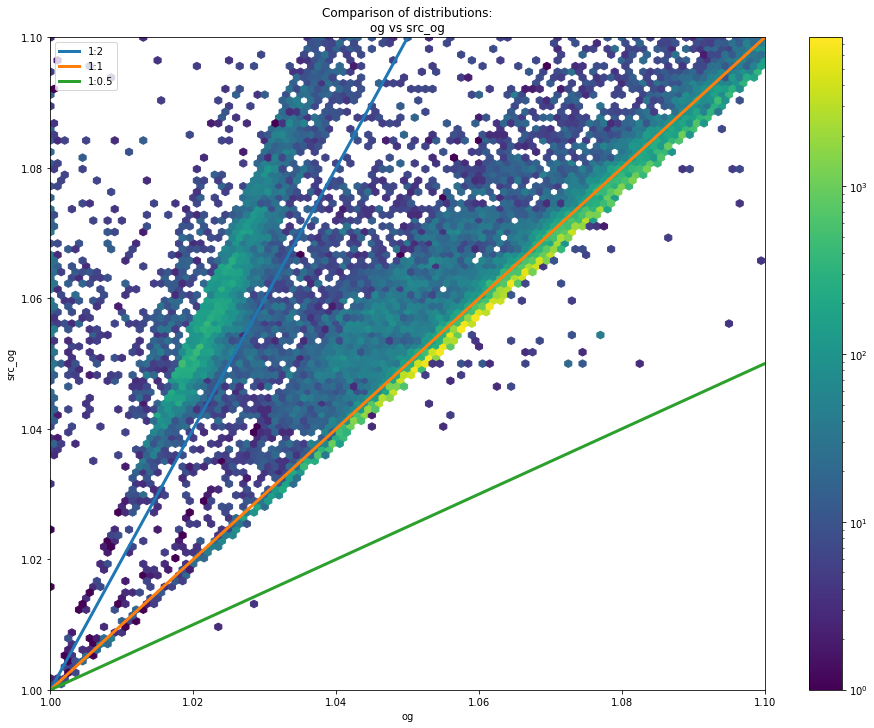

In [162]:
plot_hexbin_gravity_dist(bf, "og", "src_og")

## OG Correction #1: Moisture

The biggest difference in the Brewer's Friend OGs and ours is that our highest density bins fall *just under the 1:1 guide line*.
This means that we're systematically over-estimating OGs by a small factor. What could fix for this?


Adjusting for moisture! 


According to the American maltster Briess, [malt is typically 3-6% moisture](http://blog.brewingwithbriess.com/understanding-a-malt-analysis/). Brewer's Friend [suggests applying a 4% correction](https://www.brewersfriend.com/2012/11/30/making-sense-of-efficiency-definitions/) to the weight of grain to account for moisture.

Let's calculate a version of OG with a 4% correction applied and call it "V1".

In [23]:
bf["og_v1"] = og_test(bf, scale_volume_col="batch_size", ferm_yield_col="ferm_yield", efficiency_col="efficiency", adj_factor=0.96)

How does this OG compare to our previous one?

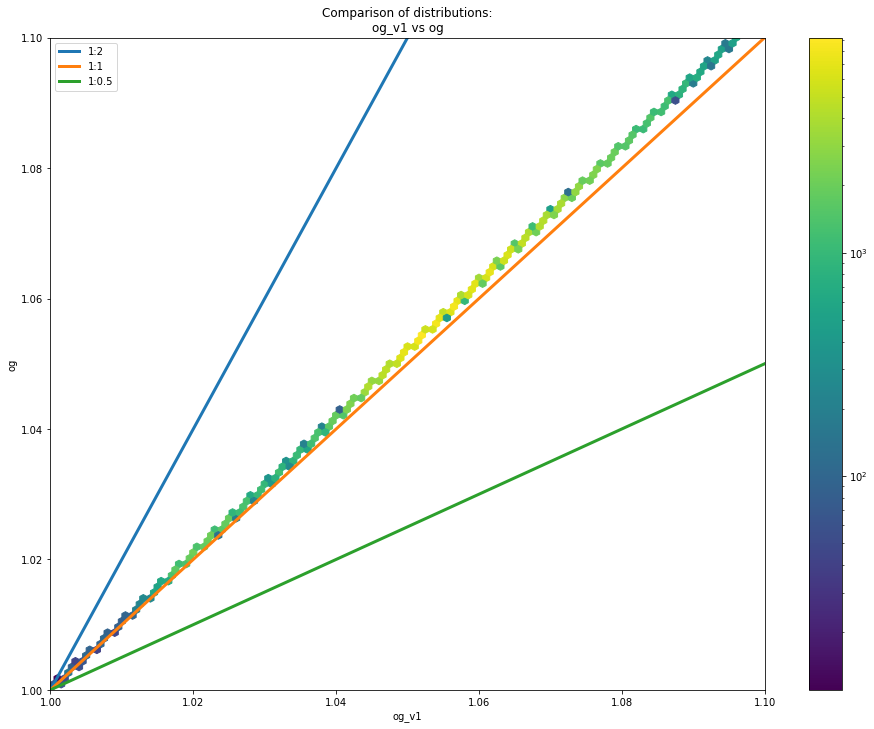

In [24]:
plot_hexbin_gravity_dist(bf, "og_v1", "og")

How does this OG compare to Brewer's Friend?

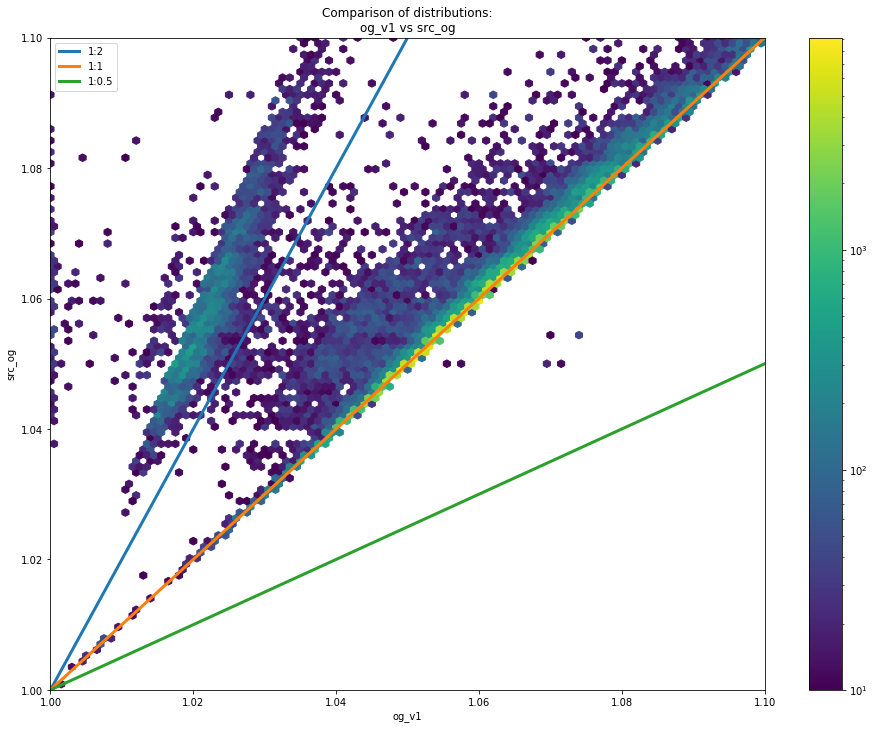

In [25]:
plot_hexbin_gravity_dist(bf, "og_v1", "src_og")

Much better!

**Correction 1: multiply gravity by 0.96 to correct for moisture**

## OG Correction #2: Low values of efficiency 

The next biggest discrepancy between our OG and Brewer's Friend are recipes *above the 1:2 guideline*. 

These are recipes where we're drammtically under-estimating OG, by a factor of more than 2. What do these have in common? (Note that there's a distinct group where our OG is very close to 0, near the y-axis. Let's ignore those for now.)

In [26]:
mask_low_og = ((bf["src_og"]-1) > ((bf["og_v1"]-1) * 2)) & (bf["og_v1"] > 1.010)

In [27]:
bf[mask_low_og][recipe_basic_cols + ferm_ingred_cols].dropna().head(25)

name              style_name  boil_size  \
id                                                                         
330793       pete & annas wedding ale  california common beer  12.000000   
330793       pete & annas wedding ale  california common beer  12.000000   
330793       pete & annas wedding ale  california common beer  12.000000   
330796      mid-mountain imperial ipa            imperial ipa  49.210353   
330796      mid-mountain imperial ipa            imperial ipa  49.210353   
330796      mid-mountain imperial ipa            imperial ipa  49.210353   
330796      mid-mountain imperial ipa            imperial ipa  49.210353   
330796      mid-mountain imperial ipa            imperial ipa  49.210353   
330800                    frankenbrew       american pale ale   9.463529   
330809           #34 orange cream ale               cream ale  11.166965   
330809           #34 orange cream ale               cream ale  11.166965   
330809           #34 orange cream ale               cream ale  11.166965   
330811         peppermint paddy stout       irish extra stout  24.605177   
330811         peppermint paddy stout       irish extra stout  24.605177   
330811         peppermint paddy stout       irish extra stout  24.605177   
330811         peppermint paddy stout       irish extra stout  24.605177   
330811         peppermint paddy stout       irish extra stout  24.605177   
330814  sweet orange half moon saison                  saison  11.356235   
330814  sweet orange half moon saison                  saison  11.356235   
330814  sweet orange half moon saison                  saison  11.356235   
330814  sweet orange half moon saison                  saison  11.356235   
330814  sweet orange half moon saison                  saison  11.356235   
330817             idaho 6 experiment            american ipa  11.000000   
330817             idaho 6 experiment            american ipa  11.000000   
330817             idaho 6 experiment            american ipa  11.000000   

        batch_size  efficiency                       ferm_name    ferm_type  \
id                                                                            
330793   24.000000        0.35        dry malt extract - light  dry extract   
330793   24.000000        0.35  dry malt extract - extra light  dry extract   
330793   24.000000        0.35                     crystal 70l        grain   
330796   37.854118        0.45     liquid malt extract - light      extract   
330796   37.854118        0.45        dry malt extract - light  dry extract   
330796   37.854118        0.45           caramel / crystal 15l        grain   
330796   37.854118        0.45           caramel / crystal 40l        grain   
330796   37.854118        0.45                      flaked rye      adjunct   
330800   14.952377        0.35     liquid malt extract - amber      extract   
330809   20.819765        0.35     liquid malt extract - light      extract   
330809   20.819765        0.35                     flaked corn      adjunct   
330809   20.819765        0.35       dry malt extract - pilsen  dry extract   
330811   20.819765        0.35      liquid malt extract - dark      extract   
330811   20.819765        0.35         dry malt extract - dark  dry extract   
330811   20.819765        0.35            lactose (milk sugar)        sugar   
330811   20.819765        0.35                  roasted barley        grain   
330811   20.819765        0.35                       chocolate        grain   
330814   18.927059        0.35     liquid malt extract - light      extract   
330814   18.927059        0.35                           honey        sugar   
330814   18.927059        0.35                          vienna        grain   
330814   18.927059        0.35                    flaked wheat      adjunct   
330814   18.927059        0.35                     flaked oats      adjunct   
330817   21.000000        0.35     liquid malt extract - light      extract   
33081

They appear to have very low efficiencies! What's the distribution of efficiencies like for these recipes?

In [28]:
bf[mask_low_og]["efficiency"].value_counts().head(10)

0.35    33453
0.25     1659
0.30      485
0.40      435
0.75      184
0.45      124
0.20      121
0.15       87
0.70       44
0.33       42
Name: efficiency, dtype: int64

Almost all of these recipes have efficiency > 0.5. 

This seems unphysical! Even very beginner homebrewing setups get above 50% efficiency. What happens when we correct efficiency by replacing values below 0.50 with the mean?

In [29]:
def split_series_on_range(series, min_value, max_value):
    inside_mask = series.between(min_value, max_value)
    inside = series[inside_mask]
    outside = series[~inside_mask]
    return inside, outside

In [30]:
def replace_with_mean(series, acceptable_min=0.5, acceptable_max=1.0):
    """ Replace unacceptable quantities in a series with the mean acceptable quantity. """
    good, bad = split_series_on_range(series, acceptable_min, acceptable_max)
    mean_good = good.groupby(good.index).first().mean()
    fixed_series = good.append(pd.Series(index=bad.index, data=mean_good))
    return fixed_series.sort_index()

In [31]:
bf["eff_adj_mean"]  = replace_with_mean(bf["efficiency"])

What effect does correcting these efficiencies have on OG?

Let's calculate another version of OG from these efficiences. This one is version 2.

In [32]:
bf["og_v2"] = og_test(bf, scale_volume_col="batch_size", ferm_yield_col="ferm_yield", efficiency_col="eff_adj_mean", adj_factor=0.96)

How does this help for the problematic recipes we identified?

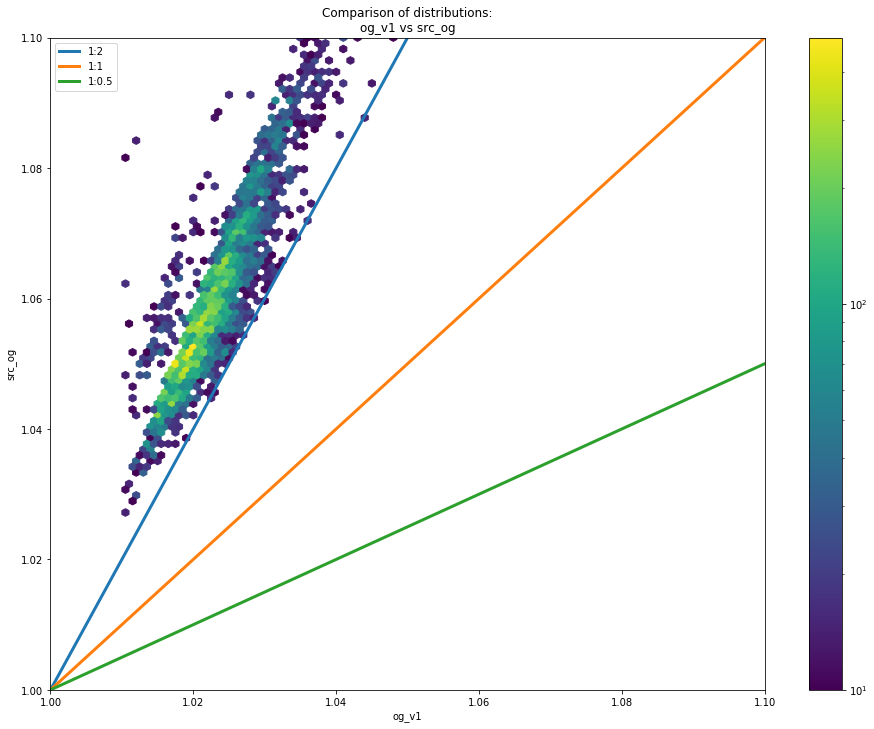

In [34]:
plot_hexbin_gravity_dist(bf[mask_low_og], "og_v1", "src_og")

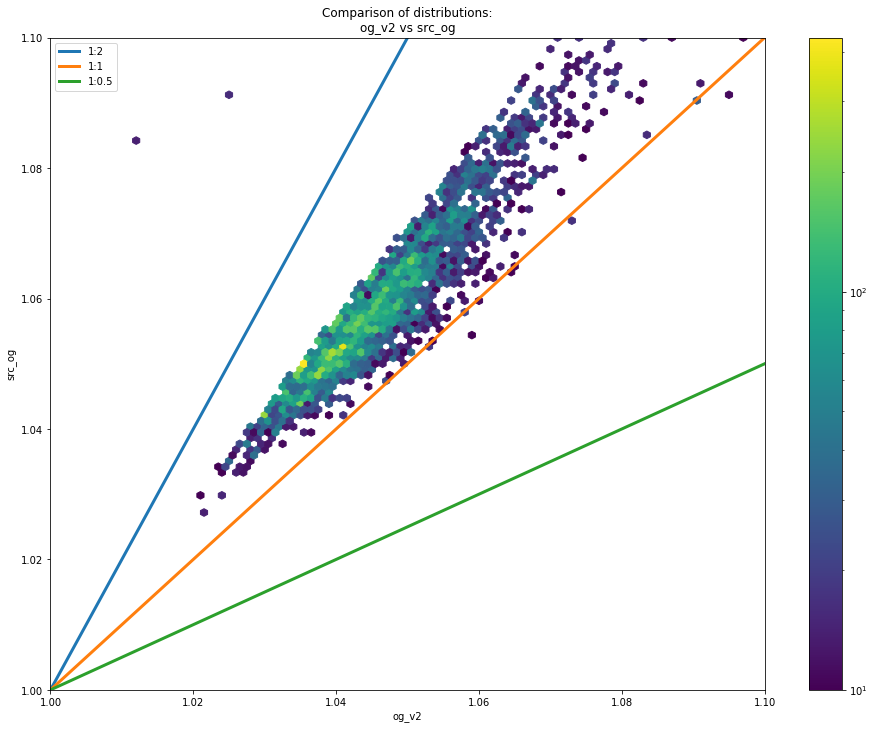

In [96]:
plot_hexbin_gravity_dist(bf[mask_low_og], "og_v2", "src_og")

How much closer does this bring us to Brewer's Friend overall?

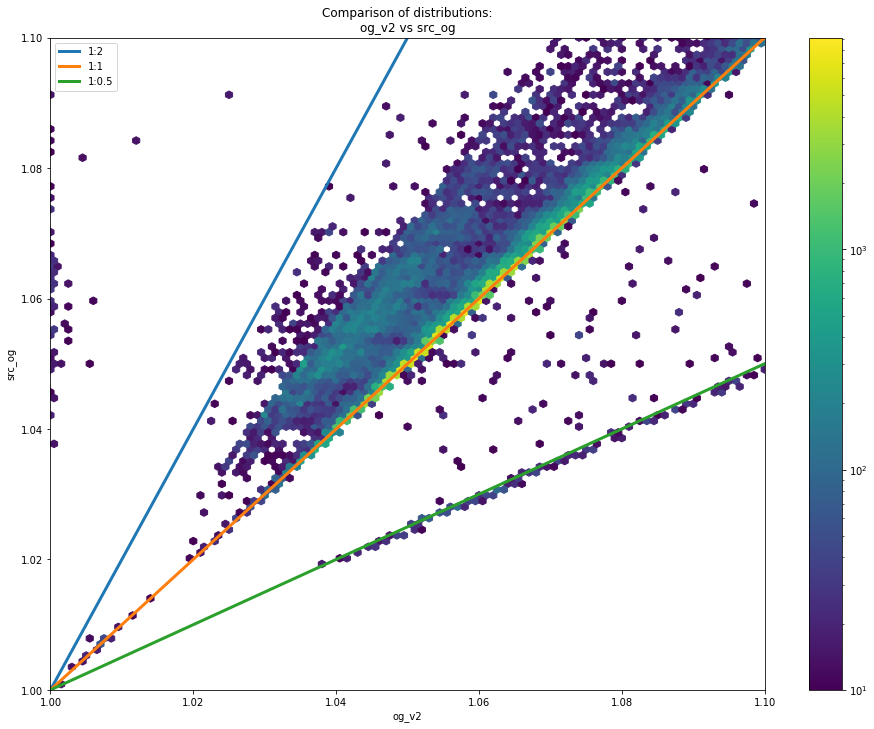

In [35]:
plot_hexbin_gravity_dist(bf, "og_v2", "src_og")

This is better, but it's not perfect. What else could be going on?

We'll keep this correction, and keep digging:

**Correction 2: replace efficiencies below 0.50 by the mean efficiency outside of that range**

# OG Correction #3: Efficiency for non-grain fermentables

What else is in common with these recipes?

In [98]:
bf[mask_low_og][recipe_basic_cols + ferm_ingred_cols].dropna().head(15)

name              style_name  boil_size  \
id                                                                     
330793   pete & annas wedding ale  california common beer  12.000000   
330793   pete & annas wedding ale  california common beer  12.000000   
330793   pete & annas wedding ale  california common beer  12.000000   
330796  mid-mountain imperial ipa            imperial ipa  49.210353   
330796  mid-mountain imperial ipa            imperial ipa  49.210353   
330796  mid-mountain imperial ipa            imperial ipa  49.210353   
330796  mid-mountain imperial ipa            imperial ipa  49.210353   
330796  mid-mountain imperial ipa            imperial ipa  49.210353   
330800                frankenbrew       american pale ale   9.463529   
330809       #34 orange cream ale               cream ale  11.166965   
330809       #34 orange cream ale               cream ale  11.166965   
330809       #34 orange cream ale               cream ale  11.166965   
330811     peppermint paddy stout       irish extra stout  24.605177   
330811     peppermint paddy stout       irish extra stout  24.605177   
330811     peppermint paddy stout       irish extra stout  24.605177   

        batch_size  efficiency                       ferm_name    ferm_type  \
id                                                                            
330793   24.000000        0.35        dry malt extract - light  dry extract   
330793   24.000000        0.35  dry malt extract - extra light  dry extract   
330793   24.000000        0.35                     crystal 70l        grain   
330796   37.854118        0.45     liquid malt extract - light      extract   
330796   37.854118        0.45        dry malt extract - light  dry extract   
330796   37.854118        0.45           caramel / crystal 15l        grain   
330796   37.854118        0.45           caramel / crystal 40l        grain   
330796   37.854118        0.45                      flaked rye      adjunct   
330800   14.952377        0.35     liquid malt extract - amber      extract   
330809   20.819765        0.35     liquid malt extract - light      extract   
330809   20.819765        0.35                     flaked corn      adjunct   
330809   20.819765        0.35       dry malt extract - pilsen  dry extract   
330811   20.819765        0.35      liquid malt extract - dark      extract   
330811   20.819765        0.35         dry malt extract - dark  dry extract   
330811   20.819765        0.35            lactose (milk sugar)        sugar   

        ferm_amount  ferm_yield  ferm_color  
id                                           
330793     2.000000      0.9130         4.0  
330793     1.000000      0.9130         2.5  
330793     0.400000      0.7391        70.0  
330796     5.443108      0.7609         4.0  
330796     4.082331      0.9130         4.0  
330796     0.907185      0.7609        15.0  
330796     0.907185      0.7391        40.0  
330796     0.453592      0.7826         2.8  
330800     2.721554      0.7609        10.0  
330809     1.496855      0.7609         4.0  
330809     0.453592      0.8696         0.5  
330809     1.088622      0.9130         2.0  
330811     2.721554      0.7609        30.0  
330811     0.907185      0.9565        30.0  
330811     0.453592      0.8913         1.0

A lot of these recipes are made with sugar and malt extract!

Are these fermentable types more common than in the dataset as a whole?

In [36]:
extract_mask = bf["ferm_type"].isin(["sugar", "dry extract", "extract"])

In [38]:
bf["ferm_type"].value_counts(normalize=True)

grain          0.805611
adjunct        0.074889
sugar          0.057451
dry extract    0.034312
extract        0.027737
Name: ferm_type, dtype: float64

In [102]:
bf[mask_low_og]["ferm_type"].value_counts(normalize=True)

grain          0.460842
dry extract    0.197074
extract        0.188491
sugar          0.114451
adjunct        0.039141
Name: ferm_type, dtype: float64

Do these fermentable types have the same names in the Brewtoad dataset?

In [39]:
bt = load_recipes(brewtoad_indices) 
bt["ferm_type"].value_counts()

caramel/crystal malt    58761
grain                   54451
adjunct                 48493
base malt               45292
kilned malt             35243
roasted malt            28558
sugar                   15266
liquid extract          15015
dry extract             14435
mash                       25
Name: ferm_type, dtype: int64

They're similar but not quite the same. So here's the list of ferm_types that correspond to sugars or extracts:

In [40]:
extract_types = ["sugar", "dry extract", "liquid extract", "extract"]

Let's inspect some examples to sanity check.

In [41]:
bf[bf["ferm_type"].isin(extract_types)].groupby(["ferm_type", "ferm_name"])["batch_size"].count().head(25)

ferm_type    ferm_name                              
dry extract  dry malt extract - amber                   1189
             dry malt extract - dark                     708
             dry malt extract - extra light             1228
             dry malt extract - light                   4271
             dry malt extract - munich                   168
             dry malt extract - pilsen                  1223
             dry malt extract - wheat                   1204
             rice syrup solids                           107
extract      liquid malt extract - amber                1144
             liquid malt extract - dark                  653
             liquid malt extract - extra light           546
             liquid malt extract - light                3191
             liquid malt extract - maris otter           231
             liquid malt extract - munich                481
             liquid malt extract - pilsen               1072
             liquid malt extract

In [106]:
check_result = bt[bt["ferm_type"].isin(extract_types)].groupby(["ferm_type", "ferm_name"])["batch_size"].count()
check_result[check_result > 200].head(25)

ferm_type       ferm_name                     
dry extract     amber dme                          341
                bavarian wheat dme                 829
                dark dry malt extract              222
                dry malt extract - amber           409
                dry malt extract - dark            227
                dry malt extract - extra light     608
                dry malt extract - light          1813
                dry malt extract - pilsen          757
                dry malt extract - wheat           550
                golden light dme                  3411
                light dry extract                  339
                light dry malt extract             489
                pilsen light dme                  1328
                plain extra light dme              218
                plain light dme                    359
                sparkling amber dme                636
                wheat dme                          290
liquid extract  br

Looks good. Let's adjust efficiency for thest fermentable types, and calculate a new OG from it.

Since they're added directly to the kettle, the efficiency should be 1.

In [44]:
def adjust_efficiency(df, col_efficiency, ferm_types_extract, new_efficiency=1):
    """
    Return a Series of adjusted efficiencies based on the ferm_type / name.
    """
    extract_mask = df["ferm_type"].isin(ferm_types_extract)
    extract_inds = np.where(extract_mask)[0]
    other_mask = ~extract_mask
    other_inds = np.where(other_mask)[0]

    extract_eff = pd.Series(new_efficiency * np.ones(len(extract_inds)), index=extract_inds)
    other_eff = df.loc[other_mask, "efficiency"]
    other_eff.index = other_inds

    all_ferms = extract_eff.append(other_eff).sort_index()
    all_ferms.index = df.index
    return all_ferms

In [45]:
bf["eff_adj_mean_type"] = adjust_efficiency(bf, col_efficiency="eff_adj_mean", ferm_types_extract=extract_types, new_efficiency=1)

This is our third OG calculation.

In [46]:
bf["og_v3"] = og_test(bf, scale_volume_col="batch_size", ferm_yield_col="ferm_yield", efficiency_col="eff_adj_mean_type", adj_factor=0.96)

How much closer to Brewer's Friend does this get us for the problematic recipes?

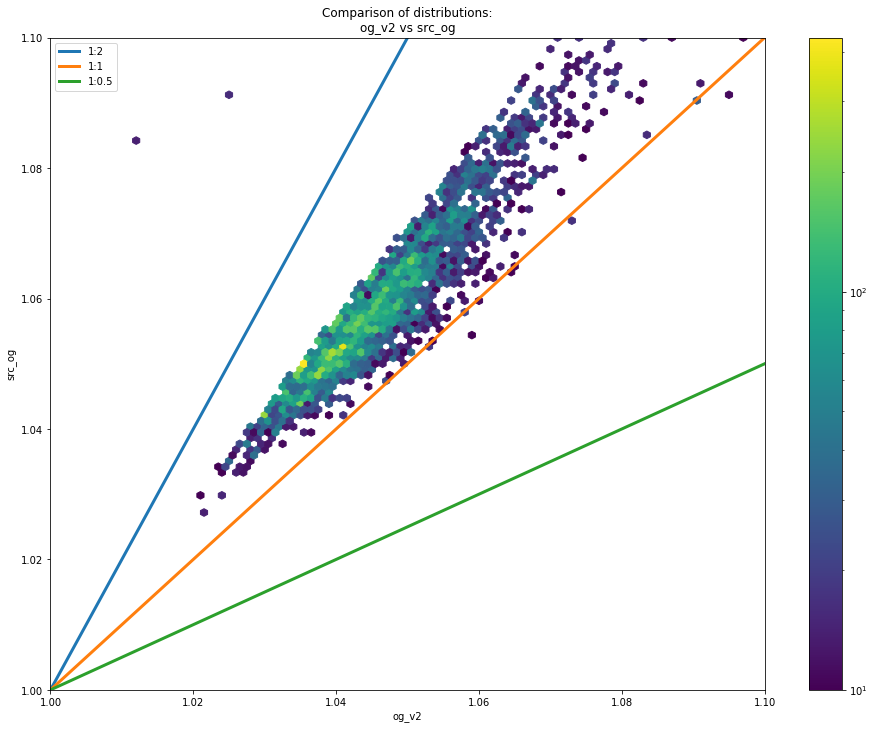

In [47]:
plot_hexbin_gravity_dist(bf[mask_low_og], "og_v2", "src_og")

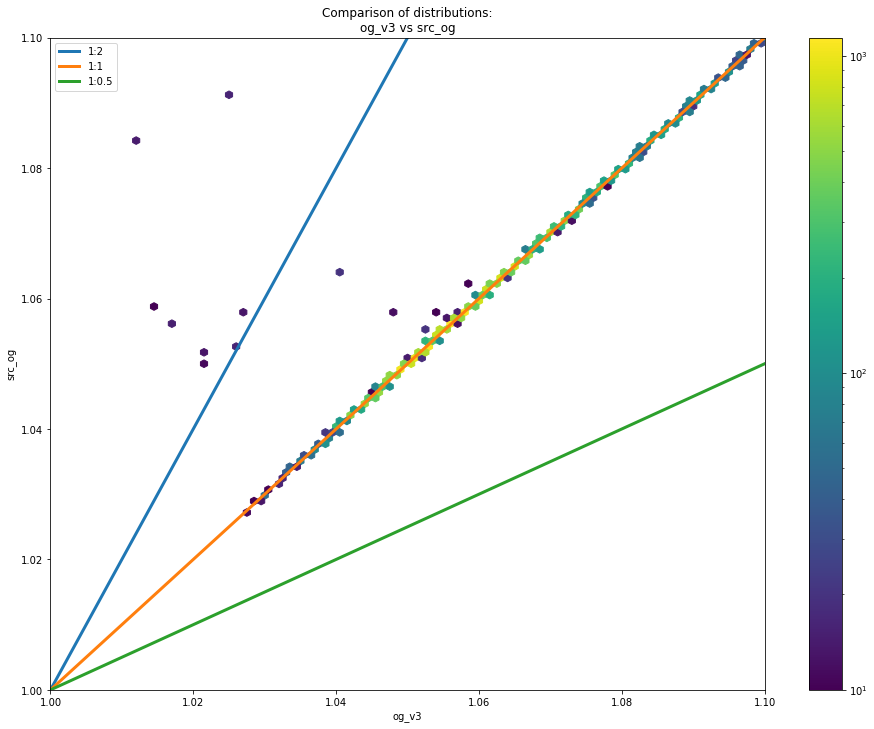

In [110]:
plot_hexbin_gravity_dist(bf[mask_low_og], "og_v3", "src_og")

Way better! Wow! What does the distribution look like overall now?

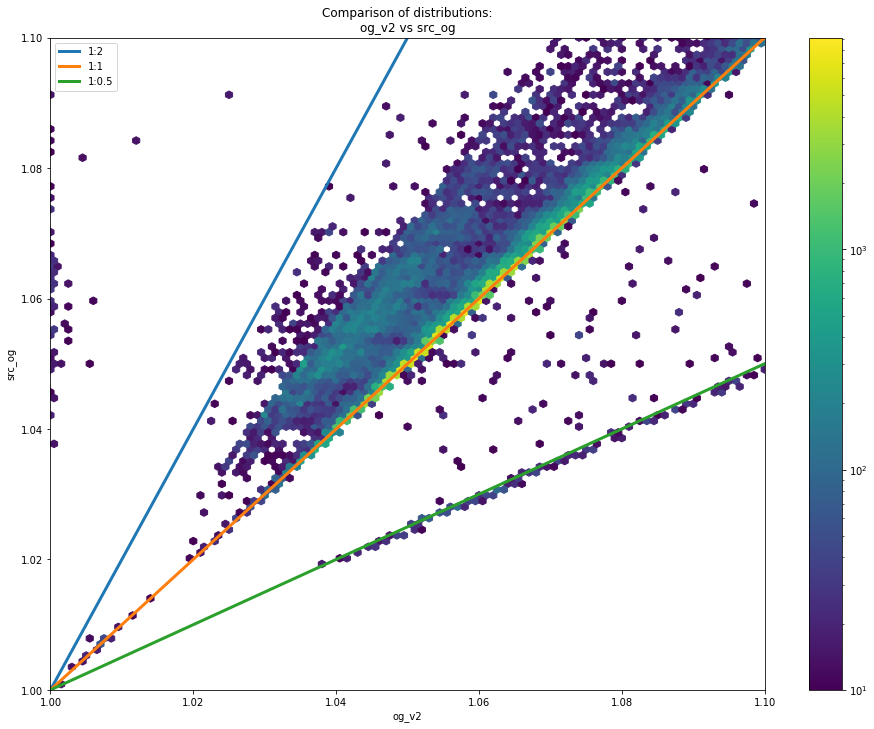

In [49]:
plot_hexbin_gravity_dist(bf, "og_v2", "src_og")

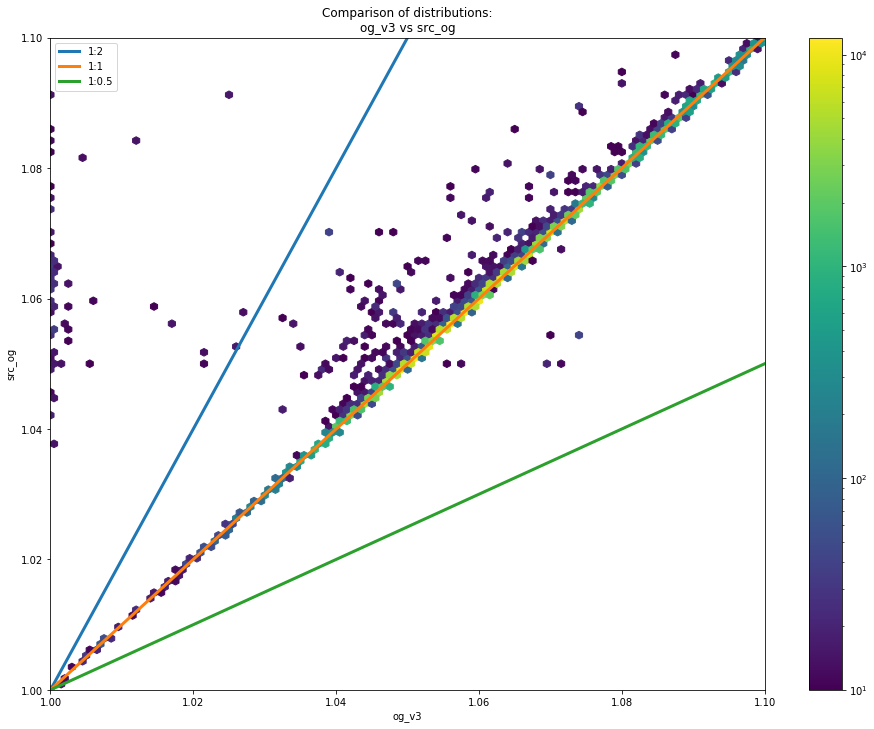

In [48]:
plot_hexbin_gravity_dist(bf, "og_v3", "src_og")

Sanity check: What happened to the recipes at the 1:0.5 line?

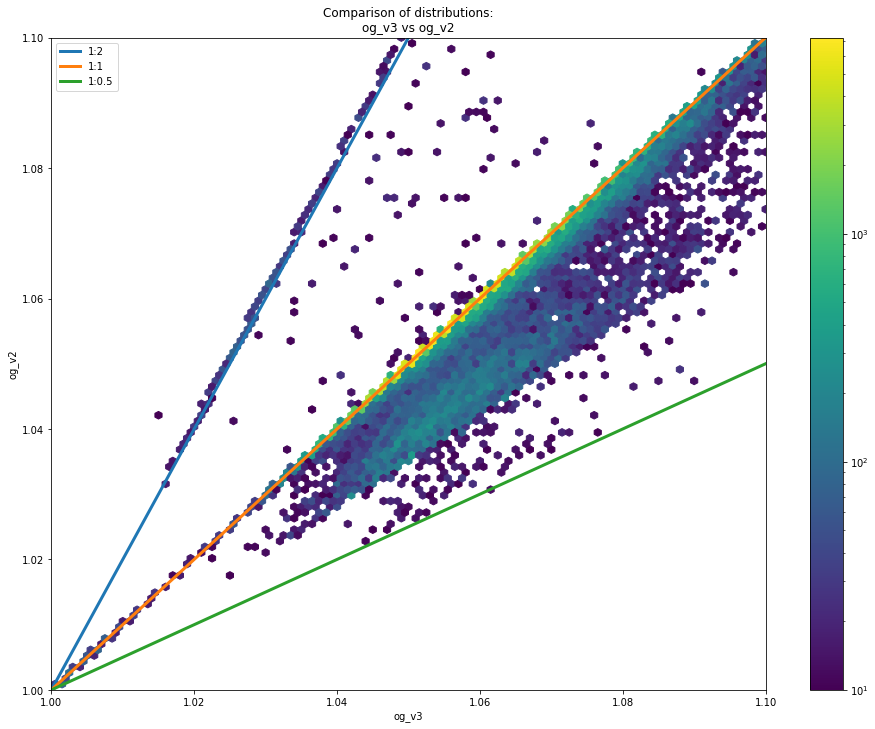

In [166]:
plot_hexbin_gravity_dist(bf, "og_v3", "og_v2")

Looks like they were rectified by doubling in our new correction to OG. We've killed two birds with one stone.

This is an important correction!

**Correction 3: replace efficiencies for ferm_types corresponding to extracts and sugars with 1**

# OG Correction #4: Fill in fermentable yields that are 0

The last remaining obvious discrepancy between our OG and Brewer's Friend are the recipes near the y-axis.

These are recipes where the Brewer's friend OG is very very low. What do they have in common?

In [113]:
mask_bf_low_og = bf["src_og"] < 1.005

In [114]:
bf[mask_bf_low_og][recipe_basic_cols + ferm_ingred_cols].dropna().head(30)

name              style_name   boil_size  \
id                                                                       
331547   blood orange and bergamot    american light lager  180.000000   
331955                  hefeweizen            dunkelweizen   18.000000   
332552              awesome recipe      american amber ale   22.712471   
333590                frankenstout  russian imperial stout   15.141647   
334309      chai tea coconut stout           oatmeal stout    3.785412   
336148                     cider 3            common cider    9.463529   
336642  nut brown ale partial mash      american brown ale   18.927059   
336642  nut brown ale partial mash      american brown ale   18.927059   
336642  nut brown ale partial mash      american brown ale   18.927059   
336642  nut brown ale partial mash      american brown ale   18.927059   
336642  nut brown ale partial mash      american brown ale   18.927059   
337444              awesome recipe    american light lager   28.390588   
337444              awesome recipe    american light lager   28.390588   
337444              awesome recipe    american light lager   28.390588   
337444              awesome recipe    american light lager   28.390588   
337444              awesome recipe    american light lager   28.390588   
337444              awesome recipe    american light lager   28.390588   
337444              awesome recipe    american light lager   28.390588   
337444              awesome recipe    american light lager   28.390588   
337444              awesome recipe    american light lager   28.390588   
337444              awesome recipe    american light lager   28.390588   
337511           testing custom dp    american light lager   28.390588   
340777    tennessee imperial state          imperial stout   26.497882   
341432                  team gamma         american porter    3.785412   
341432                  team gamma         american porter    3.785412   
341432                  team gamma         american porter    3.785412   
341432                  team gamma         american porter    3.785412   
341432                  team gamma         american porter    3.785412   
342072       chief's trail ale #14       american pale ale   18.927059   
342072       chief's trail ale #14       american pale ale   18.927059   

        batch_size  efficiency                                 ferm_name  \
id                                                                         
331547  165.000000        0.80                             flaked barley   
331955   18.000000        0.75                                cane sugar   
332552   56.781177        0.35                             flaked barley   
333590   22.712471        0.35                                 chocolate   
334309    9.463529        0.75          sticky wicket oat meal stout hme   
336148    9.463529        0.00                  dry malt extract - amber   
336642   18.927059        0.75                       simpson's chocolate   
336642   18.927059        0.75                         belgian special b   
336642   18.927059        0.75                      belgian biscuit malt   
336642   18.927059        0.75                     briess american 2-row   
336642   18.927059        0.75  northern brewer gold liquid malt extract   
337444   20.819765        0.70                                    munich   
337444   20.819765        0.70                                 chocolate   
337444   20.819765        0.70                                     wheat   
337444   20.819765        0.70                                caramunich   
337444   20.819765        0.70                              caramel pils   
337444   20.819765        0.70                              black patent   
337444   20.819765        0.70                                 cara malt   
337444   20.819765        0.70                               rolled oats   
337444   20.819765        0.70                                car

Lots of these recipes have low ferm_yields! Some are even 0.

What's the distribution of ferm_yields like for these recipes?

In [115]:
bf[mask_bf_low_og]["ferm_yield"].value_counts(normalize=True).head(10)

0.0000    0.191919
0.6957    0.131313
0.0217    0.111111
0.7609    0.101010
0.9130    0.060606
0.7391    0.060606
0.7174    0.050505
0.8043    0.030303
0.0225    0.030303
0.9783    0.030303
Name: ferm_yield, dtype: float64

What about in total for our dataset?

In [52]:
bf["ferm_yield"].value_counts(normalize=True).head(10)

0.8043    0.197940
0.7174    0.153336
0.7391    0.152123
0.8261    0.123445
0.7609    0.098440
0.9130    0.040686
0.6957    0.036092
0.7826    0.033768
0.6304    0.029820
1.0000    0.022110
Name: ferm_yield, dtype: float64

It looks like ferm_yields from 0 to 0.0225 are way more common in these problematic recipes than overall.

Let's fix them by setting them to the mean for the ferm_type. An important exception is rice hulls, which we need to make sure have a ferm_yield = 0.

In [51]:
ferm_yield_cutoff = 0.03

In [53]:
good_ferm_yield_mask = bf["ferm_yield"] > ferm_yield_cutoff
bad_ferm_yield_mask = bf["ferm_yield"] <= ferm_yield_cutoff
non_rice_hulls_mask = bf["ferm_name"] != "rice hulls"

In [54]:
ferm_yield_mean = bf[good_ferm_yield_mask & non_rice_hulls_mask].groupby("ferm_type")["ferm_yield"].mean()
ferm_yield_mean

ferm_type
adjunct        0.742587
dry extract    0.914883
extract        0.764420
grain          0.758901
sugar          0.915080
Name: ferm_yield, dtype: float64

In [55]:
ferm_yield_ind_to_replace = bf[bad_ferm_yield_mask & non_rice_hulls_mask].index
bf["ferm_yield_adj"] = bf["ferm_yield"]
bf.loc[ferm_yield_ind_to_replace, "ferm_yield_adj"] = bf.loc[ferm_yield_ind_to_replace, "ferm_type"].map(ferm_yield_mean)

Let's sanity check the replacements worked.

In [56]:
bf[~bf["ferm_name"].isna()].loc[ferm_yield_ind_to_replace][["ferm_name", "ferm_yield", "ferm_yield_adj"]].head(10)

ferm_name  ferm_yield  ferm_yield_adj
id                                                 
330883  barley (flaked)         0.0        0.758901
330883   munich (light)         0.0        0.758901
330883      crystal 10l         0.0        0.758901
330883     malt - amber         0.0        0.758901
330883  barley (flaked)         0.0        0.758901
330883   munich (light)         0.0        0.758901
330883      crystal 10l         0.0        0.758901
330883     malt - amber         0.0        0.758901
330883  barley (flaked)         0.0        0.758901
330883   munich (light)         0.0        0.758901

Finally, what the effect on OG?

This is our fourth OG calculation.

In [57]:
bf["og_v4"] = og_test(bf, scale_volume_col="batch_size", ferm_yield_col="ferm_yield_adj", efficiency_col="eff_adj_mean_type", adj_factor=0.96)

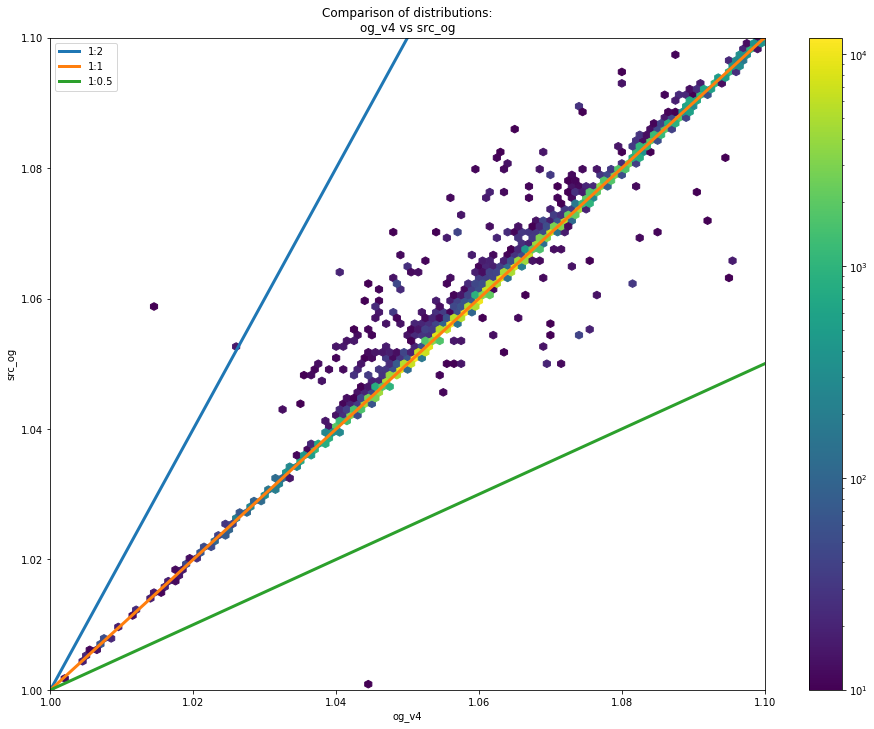

In [58]:
plot_hexbin_gravity_dist(bf, "og_v4", "src_og")

Much better!

**Correction 4: replace low ferm_yields for fermentables other than rice hulls with the mean for the ferm_type**

### Summary of OG corrections
* Correction 1: multiply gravity by 0.96% to correct for moisture
* Correction 2: replace efficiencies below 0.50 by the mean efficiency outside of that range
* Correction 3: replace efficiencies for ferm_types corresponding to extracts and sugars with 1
* Correction 4: replace ferm_yields below 0.03 for fermentables other than rice hulls with the mean outside of that range for the ferm_type


# Investigation 1.5: FG and ABV

Calculate FG and ABV from our corrected OG.

In [60]:
bf["fg"] = gravity_final(bf, og_col="og_v4")

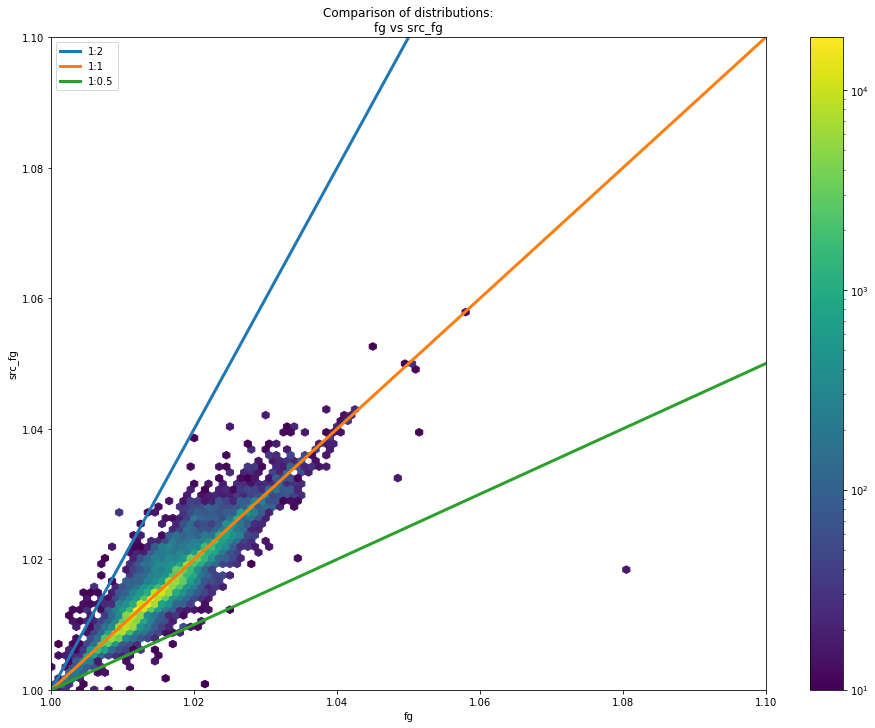

In [61]:
plot_hexbin_gravity_dist(bf, "fg", "src_fg", value_range=[1.0, 1.10])

In [62]:
bf["abv"] = abv(bf, ferm_col="ferm_scaled", og_col="og_v4", fg_col="fg")

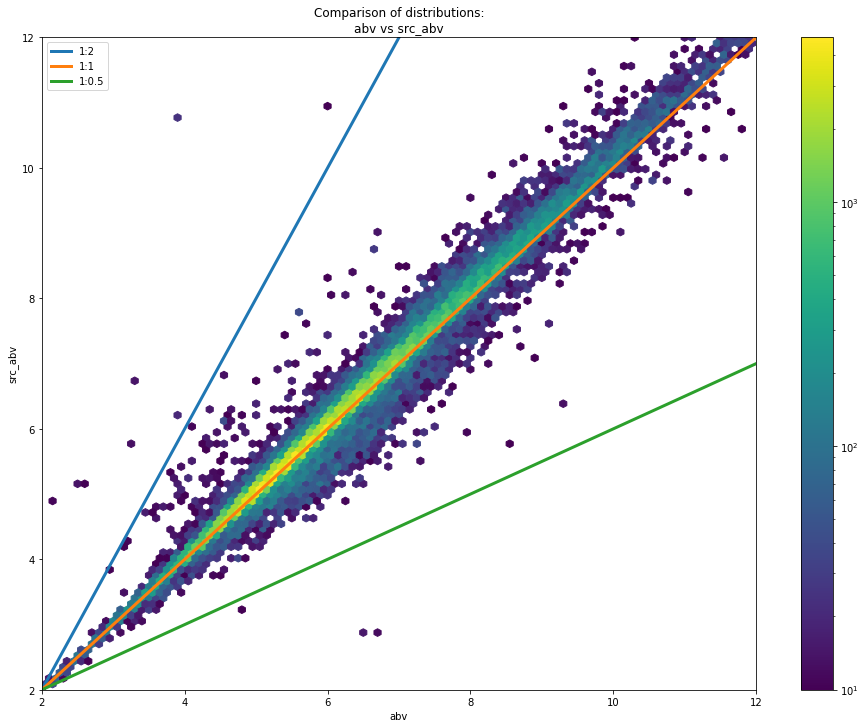

In [64]:
plot_hexbin_gravity_dist(bf, "abv", "src_abv",value_range=[2.0, 12.0])

These are both pretty darn good! Looks like our attention to OG paid off.

# Investigation 2: IBU and hop quantities

In [108]:
def ibu_test(
    df, 
    hop_col="hop_scaled",
    hop_use_col="hop_use",
    hop_time_col="hop_time",
    kettle_gravity_col="pbg",
    utilization_factor=4.15
):
    """
    *** Test version of the IBU formula ***
    Return IBU (International Bitterness Units), a measure of bitterness, for a
    recipe.
    Use the Tinseth formula:
    (Source: https://realbeer.com/hops/research.html, Glenn Tinseth)

        IBUs = utilization * mg/L alpha acids
        utilization = bigness factor * boil time factor
        bigness factor = 1.65 * 0.000125^(wort gravity - 1)
        boil time factor = (1 - e^(-0.04 * time)) / 4.15

        Where:
            wort gravity is in SG (eg. 1.051)
            time is in minutes

    Parameters:
    ===========
    df: Pandas DataFrame
        Dataframe containing scaled hop quantities and addition times.
        Dataframe assumed to have "hop_time" as a column, which represents the
        duration of boil following hop addition in minutes.
    hop_col: str, default "hop_scaled"
        Name of column containing scaled hop quantities.

    Return:
    =======
    Series representing estimate of IBU for the given recipes.
    """
    # Get rid of dry hops
    sub_df = df.loc[df[hop_use_col] != "dry hop"]
    # Turn kg/L to mg/L
    hop_amount = sub_df[hop_col] * 1000 * 1000

    boil_time_factor = (1 - np.exp(-0.04 * sub_df[hop_time_col])) / utilization_factor
    bigness_factor = 1.65 * 0.000125 ** (sub_df[kettle_gravity_col] - 1)
    utilization = boil_time_factor * bigness_factor
    ibu = utilization * hop_amount
    ibu = ibu.groupby(ibu.index).sum()
    return ibu

In [188]:
bf["hop_scaled"] = scale_hop(bf, scale_volume_boil='batch_size')

In [229]:
bf["pbg"] = og_test(bf, scale_volume_col="boil_size", ferm_yield_col="ferm_yield_adj", efficiency_col="eff_adj_mean_type", adj_factor=0.96)

Aha! Using:
* boil size for PBG
* batch size for hop_scaled 

makes a big difference.

In [230]:
bf["ibu"] = ibu_test(
    bf, 
    hop_col="hop_scaled",
    hop_use_col="hop_use",
    hop_time_col="hop_time",
    kettle_gravity_col="pbg",
    utilization_factor=3.75
)

Choosing a utilization factor of 3.75 (not Tinseth's suggested 4.15) brings the highest-density bins in line.

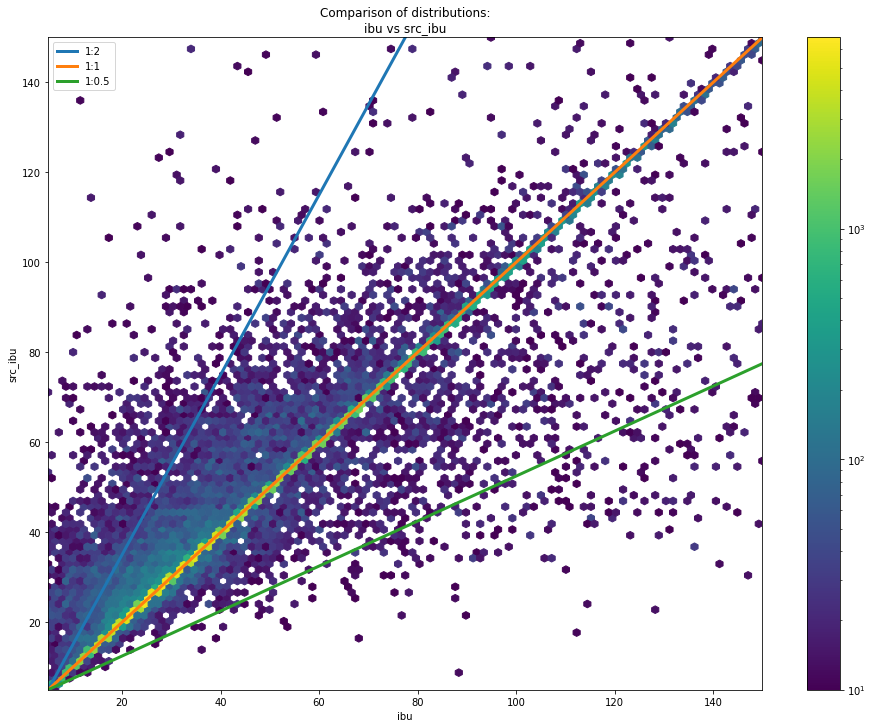

In [231]:
plot_hexbin_gravity_dist(bf, "ibu", "src_ibu", value_range=[5, 150])

# Investigation 3: SRM and fermentable colors and quantities

In [167]:
def srm_test(
    df, 
    ferm_col="ferm_scaled",
    ferm_color_col="ferm_color"
):
    """
    *** Test version of the IBU formula ***
    Return SRM (Standard Reference Method units), a measure of colour, for a
    recipe.
    Use the Morey formula:
    (Source: https://web.archive.org/web/20100402141609/http://www.brewingtechniques.com/brewingtechniques/beerslaw/morey.html)

        SRM = 1.4922 * (sum of MCU over the grain bill) ^ 0.6859
        MCU =  grain color * grain weight / kettle volume

        Where:
            grain color is in °L (degrees Lovibond)
            grain weight is in lbs
            kettle volume is in gallons

    Parameters:
    ===========
    df: Pandas DataFrame
        DataFrame containing scaled fermentable quantities and fermentable
        colors. Assumed column is "ferm_color".
    ferm_col: str, default "ferm_scaled"
        Name of column in df containing scaled fermentables

    Return:
    =======
    Series representing estimate of the SRM for the given recipes.
    """
    # ferm_amount in kg, boil_size in kg
    kg_to_lb = 2.20462
    l_to_gal = 0.264172

    # malt color units
    mcu = df[ferm_color_col] * df[ferm_col] * kg_to_lb / l_to_gal
    srm = 1.4922 * mcu.groupby(mcu.index).sum() ** 0.6859
    return srm


In [243]:
bf["ferm_scaled_boil"] = scale_ferm(bf, scale_volume="boil_size")

In [244]:
bf["ferm_scaled_batch"] = scale_ferm(bf, scale_volume="batch_size")

What happens when you use boil size?

In [245]:
bf["color_boil"] = srm_test(
    bf, 
    ferm_col="ferm_scaled_boil",
    ferm_color_col="ferm_color"
)

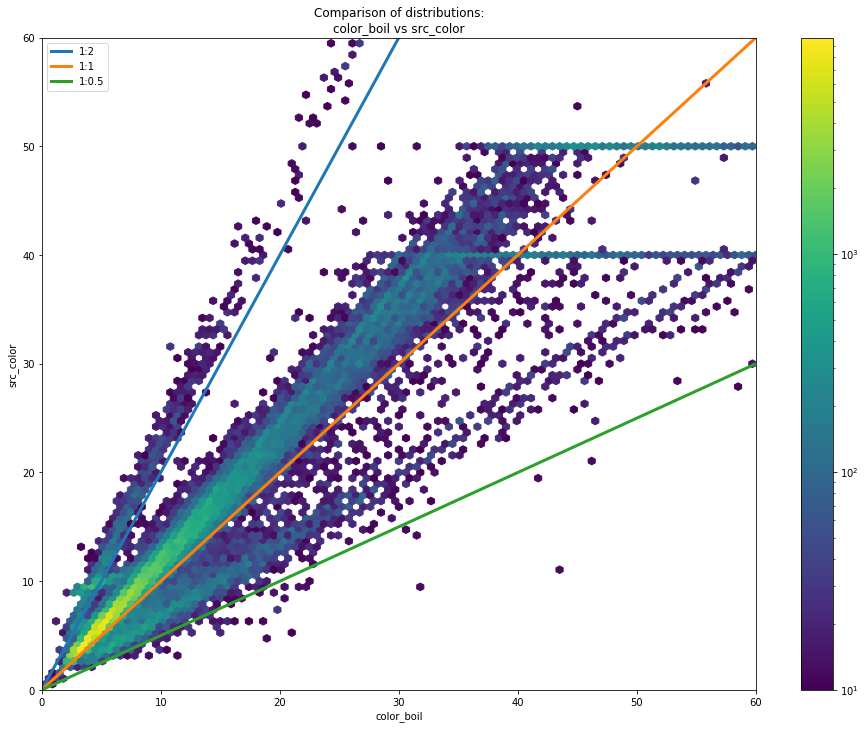

In [246]:
plot_hexbin_gravity_dist(bf, "color_boil", "src_color",value_range=[0, 60])

What happens when you use batch size?

In [247]:
bf["color_batch"] = srm_test(
    bf, 
    ferm_col="ferm_scaled_batch",
    ferm_color_col="ferm_color"
)

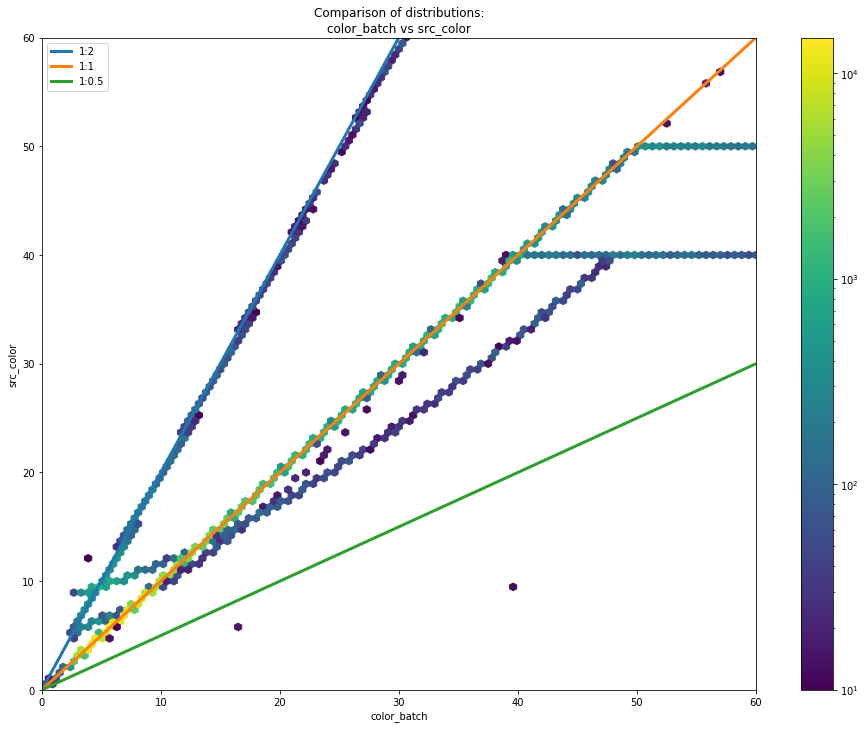

In [248]:
plot_hexbin_gravity_dist(bf, "color_batch", "src_color", value_range=[0, 60])

Batch size looks more reliable.

What's going on with the recipes that are on the 1:2 line?

In [250]:
mask_low_color = (bf["src_color"]/bf["color"]) > 1.8

In [253]:
bf[mask_low_color][color_cols + ["abv"] + ["src_abv"]].dropna().head(30)

name                  style_name  \
id                                                                            
330823           bravo bier - smoked chilli ipa  specialty ipa: belgian ipa   
330823           bravo bier - smoked chilli ipa  specialty ipa: belgian ipa   
330823           bravo bier - smoked chilli ipa  specialty ipa: belgian ipa   
330829                               hefty vice            weizen/weissbier   
330829                               hefty vice            weizen/weissbier   
330831  schwester frieda rosé – berliner fraise             berliner weisse   
330831  schwester frieda rosé – berliner fraise             berliner weisse   
330831  schwester frieda rosé – berliner fraise             berliner weisse   
330831  schwester frieda rosé – berliner fraise             berliner weisse   
330831  schwester frieda rosé – berliner fraise             berliner weisse   
330853                               dubbel 2.0              belgian dubbel   
330853                               dubbel 2.0              belgian dubbel   
330853                               dubbel 2.0              belgian dubbel   
330853                               dubbel 2.0              belgian dubbel   
330853                               dubbel 2.0              belgian dubbel   
330886                               jihadistøl      russian imperial stout   
330886                               jihadistøl      russian imperial stout   
330886                               jihadistøl      russian imperial stout   
330886                               jihadistøl      russian imperial stout   
330886                               jihadistøl      russian imperial stout   
330886                               jihadistøl      russian imperial stout   
330886                               jihadistøl      russian imperial stout   
330886                               jihadistøl      russian imperial stout   
330886                               jihadistøl      russian imperial stout   
330892                           barreiro stout         foreign extra stout   
330892                           barreiro stout         foreign extra stout   
330892                           barreiro stout         foreign extra stout   
330892                           barreiro stout         foreign extra stout   
330892                           barreiro stout         foreign extra stout   
330898                   malty ipa no1 by søren                american ipa   

         boil_size  batch_size  efficiency                   ferm_name  \
id                                                                       
330823  110.000000  100.000000        0.75                     pilsner   
330823  110.000000  100.000000        0.75                 peated malt   
330823  110.000000  100.000000        0.75       caramel / crystal 60l   
330829   28.390588   18.927059        0.72                       wheat   
330829   28.390588   18.927059        0.72                     pilsner   
330831   16.500000   15.000000        0.65                     pilsner   
330831   16.500000   15.000000        0.65                  wheat malt   
330831   16.500000   15.000000        0.65                caramel pils   
330831   16.500000   15.000000        0.65                   caraamber   
330831   16.500000   15.000000        0.65                  strawberry   
330853   18.000000   15.000000        0.70                    pale ale   
330853   18.000000   15.000000        0.70                   special b   
330853   18.000000   15.000000        0.70                    aromatic   
330853   18.000000   15.000000        0.70                  wheat malt   
330853   18.000000   15.000000        0.70  belgian candi syrup - d-90   
330886   63.000000   53.000000        0.75            maris otter pale   
330886   63.000000   53.000000        0.75                       wheat   
330886   63.000000   53.000000        0.75                 munich dark   
330886   63.000000   53.000000    

Not sure if I can find an obvious problem with these recipes!

How many of these recipes are there?

In [362]:
bf[mask_low_color].index.nunique()

3605

This isn't too too many. Maybe we can ignore them. Let's see if they produce strange results in the distributions.

# Style distributions

Now that we have cleaned-up distributions for ABV, IBU and SRM, how do they vary for each style?

In [365]:
metric_ranges = {
    "ibu": [0, 120],
    "color": [0, 60],
    "src_color": [0, 60],
    "abv": [0, 12]
}

In [354]:
def plot_dist(bf, style_name, metric_col):
    """ Plot the distribution of a metric for a single style. """
    df = bf[bf["style_name"] == style_name][metric_col]
    # Reject top and bottom 5%
    s = df.groupby(df.index).mean().dropna()
    v99 = np.percentile(s.values, 99)
    v01 = np.percentile(s.values, 5)
    s = s[s.between(v01, v99)]
    ax = sns.kdeplot(s)
    plt.xlim(metric_ranges[metric_col])
    plt.show()

In [340]:
bf["style_name"].value_counts().head(10)

american ipa              76198
american pale ale         37996
imperial ipa              11840
saison                    11585
american amber ale         9950
american light lager       8613
american stout             7298
blonde ale                 6817
russian imperial stout     6467
double ipa                 6400
Name: style_name, dtype: int64

In [327]:
bf["style_name"].value_counts().head(10).index.astype(list)

Index(['american ipa', 'american pale ale', 'imperial ipa', 'saison',
       'american amber ale', 'american light lager', 'american stout',
       'blonde ale', 'russian imperial stout', 'double ipa'],
      dtype='object')

In [350]:
most_common_styles = bf["style_name"].value_counts().head(15).index.astype(list)

Plotting ibu for style: american ipa


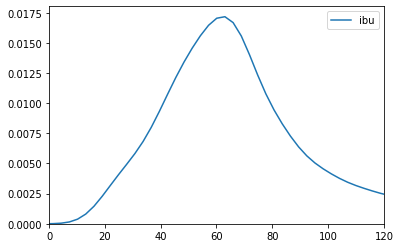

Plotting ibu for style: american pale ale


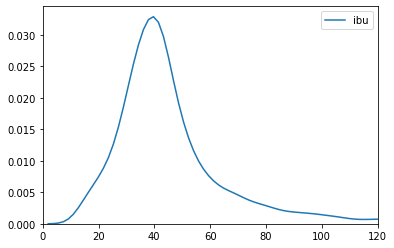

Plotting ibu for style: imperial ipa


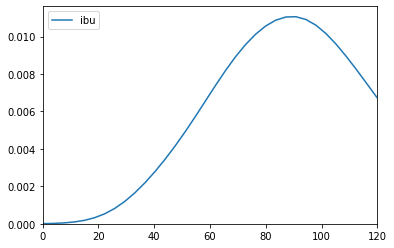

Plotting ibu for style: saison


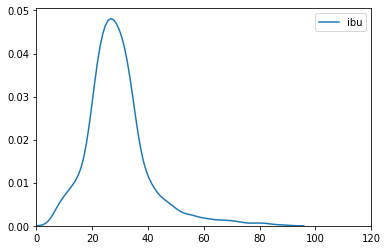

Plotting ibu for style: american amber ale


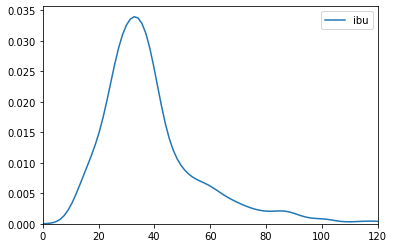

Plotting ibu for style: american light lager


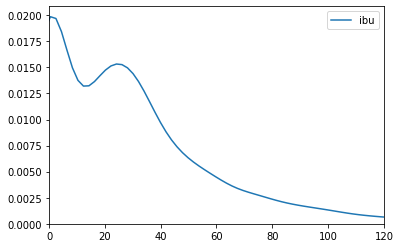

Plotting ibu for style: american stout


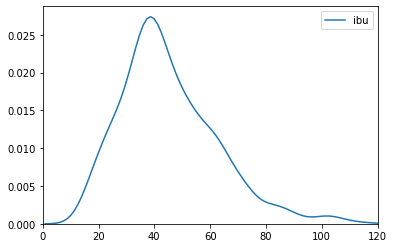

Plotting ibu for style: blonde ale


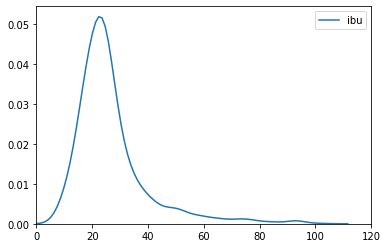

Plotting ibu for style: russian imperial stout


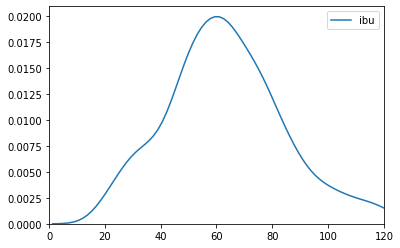

Plotting ibu for style: double ipa


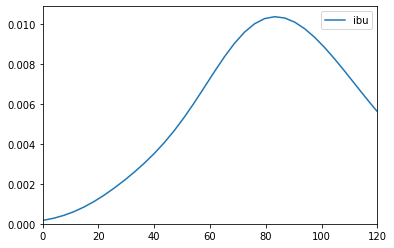

Plotting ibu for style: american brown ale


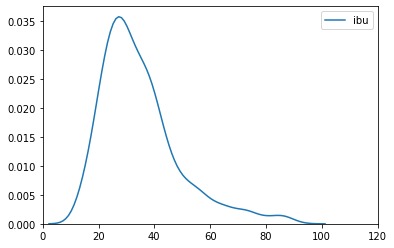

Plotting ibu for style: oatmeal stout


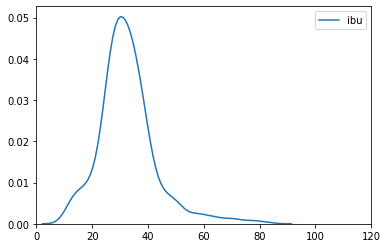

Plotting ibu for style: sweet stout


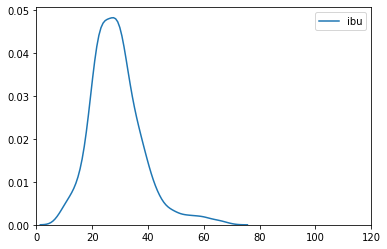

Plotting ibu for style: irish red ale


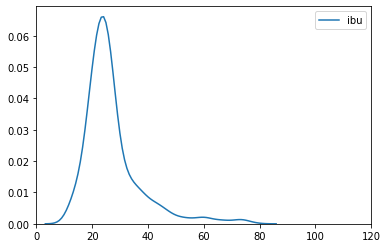

Plotting ibu for style: robust porter


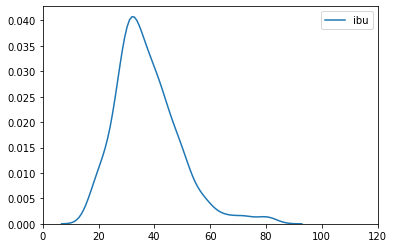

In [355]:
metric_col = "ibu"
for style in most_common_styles:
    print(f"Plotting {metric_col} for style: {style}")
    plot_dist(bf, style, metric_col)

Plotting abv for style: american ipa


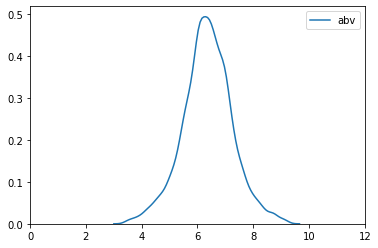

Plotting abv for style: american pale ale


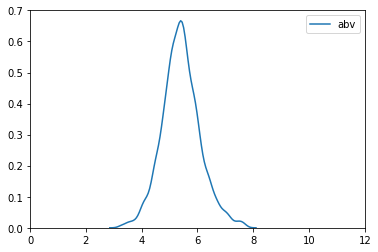

Plotting abv for style: imperial ipa


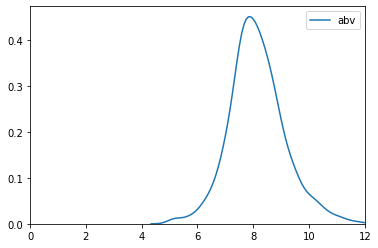

Plotting abv for style: saison


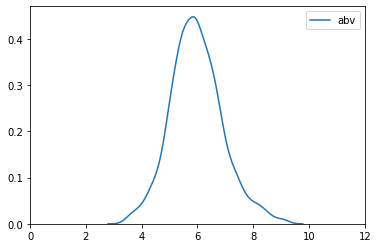

Plotting abv for style: american amber ale


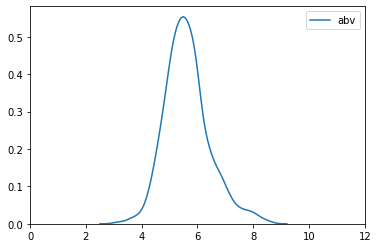

Plotting abv for style: american light lager


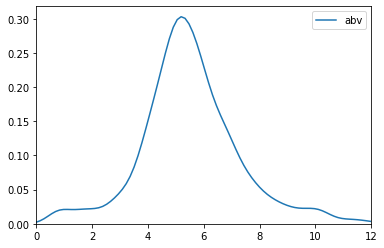

Plotting abv for style: american stout


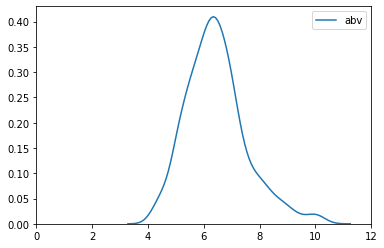

Plotting abv for style: blonde ale


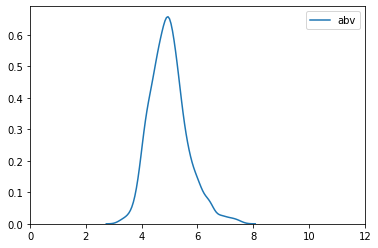

Plotting abv for style: russian imperial stout


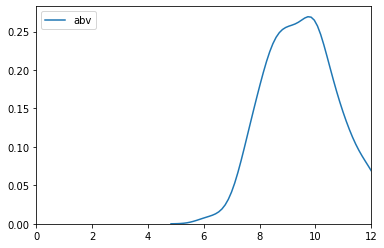

Plotting abv for style: double ipa


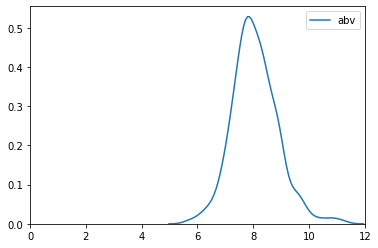

Plotting abv for style: american brown ale


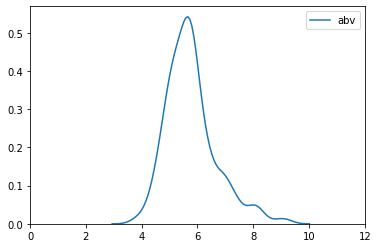

Plotting abv for style: oatmeal stout


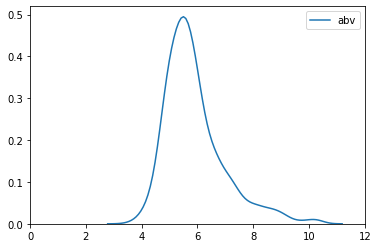

Plotting abv for style: sweet stout


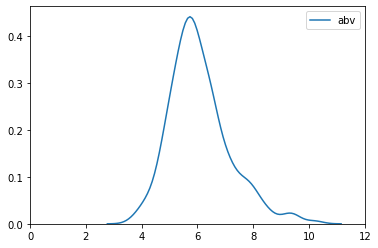

Plotting abv for style: irish red ale


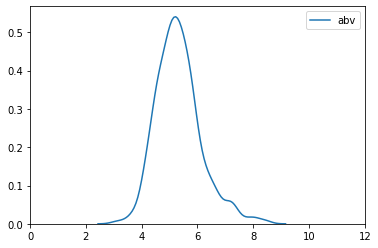

Plotting abv for style: robust porter


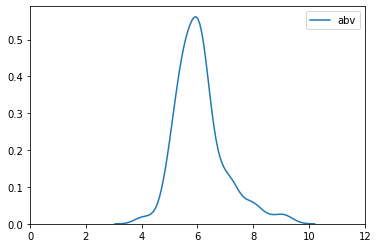

In [352]:
metric_col = "abv"
for style in most_common_styles:
    print(f"Plotting {metric_col} for style: {style}")
    plot_dist(bf, style, metric_col)

How do our calculated color distributions compare to the Brewer's friend ones?

Plotting src_color for style: american ipa


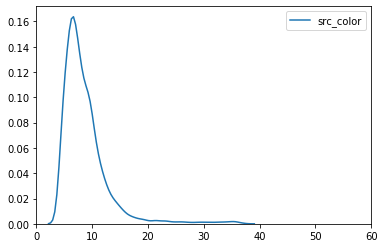

Plotting src_color for style: american pale ale


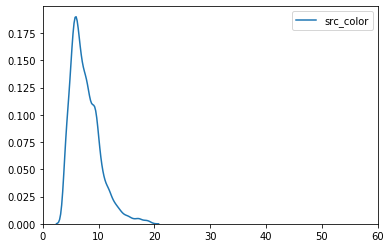

Plotting src_color for style: imperial ipa


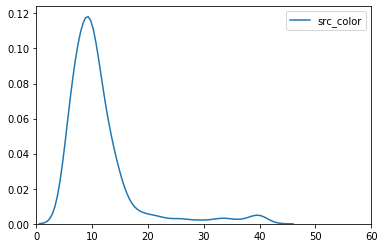

Plotting src_color for style: saison


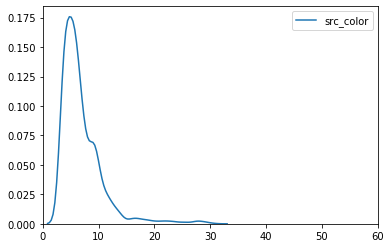

Plotting src_color for style: american amber ale


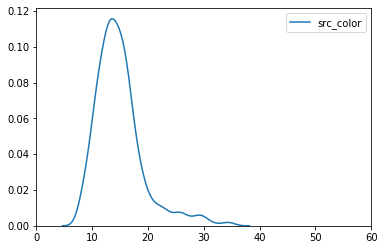

Plotting src_color for style: american light lager


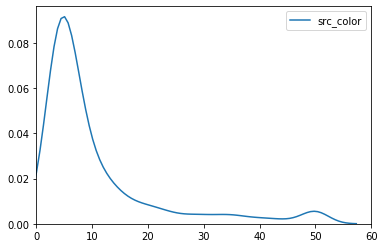

Plotting src_color for style: american stout


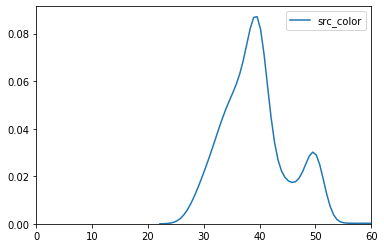

Plotting src_color for style: blonde ale


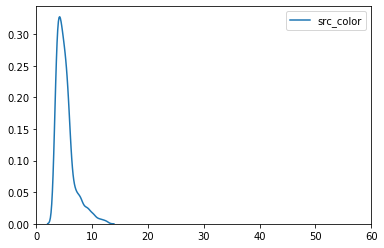

Plotting src_color for style: russian imperial stout


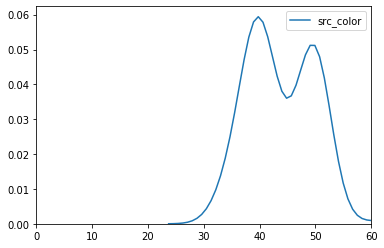

Plotting src_color for style: double ipa


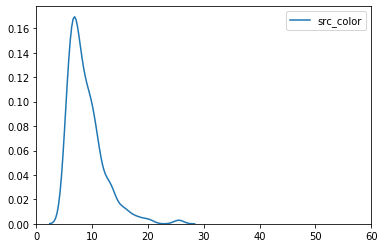

Plotting src_color for style: american brown ale


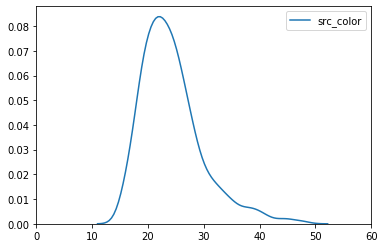

Plotting src_color for style: oatmeal stout


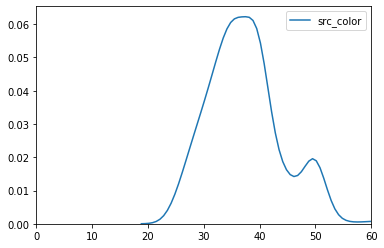

Plotting src_color for style: sweet stout


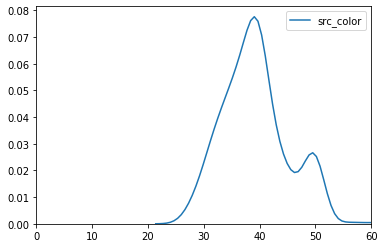

Plotting src_color for style: irish red ale


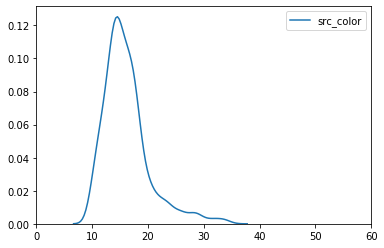

Plotting src_color for style: robust porter


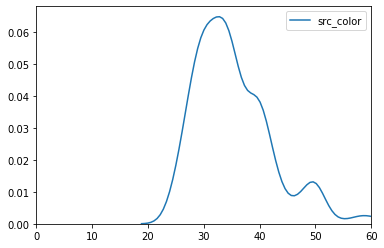

In [366]:
metric_col = "src_color"
for style in most_common_styles:
    print(f"Plotting {metric_col} for style: {style}")
    plot_dist(bf, style, metric_col)

The src color distributions actually look worse than ours! I think we can keep our calculation method.